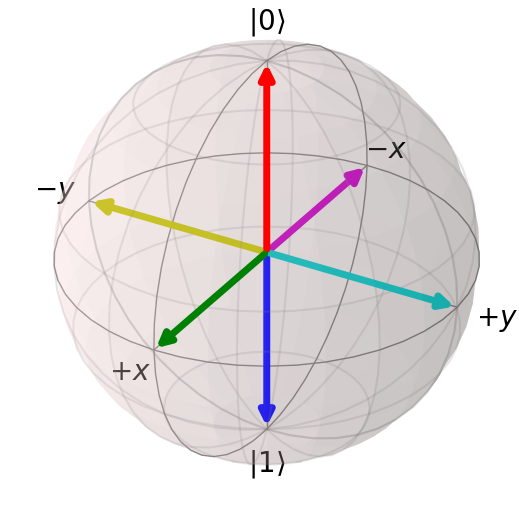

In [ ]:
from qiskit.visualization.bloch import Bloch

# Initialize Bloch sphere
bloch = Bloch()

# Add computational basis states
bloch.add_vectors([0, 0, 1])     # |0>
bloch.add_vectors([0, 0, -1])    # |1>

# Add superpositions along X
bloch.add_vectors([1, 0, 0])     # |+>
bloch.add_vectors([-1, 0, 0])    # |->

# Add superpositions along Y
bloch.add_vectors([0, 1, 0])     # |+i>
bloch.add_vectors([0, -1, 0])    # |-i>

# Assign colors for clarity
bloch.vector_color = ['r', 'b', 'g', 'm', 'c', 'y']

# Custom axis labels
bloch.xlabel = ['$+x$', '$-x$']
bloch.ylabel = ['$+y$', '$-y$']
bloch.zlabel = ['$|0⟩$', '$|1⟩$']

# Show sphere
bloch.show()


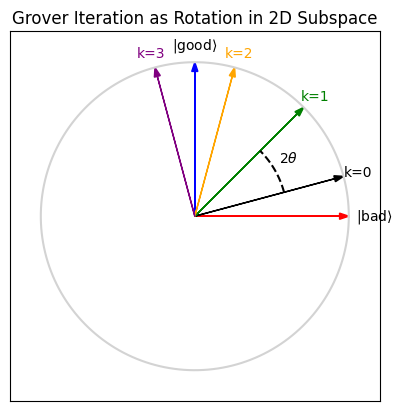

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define angle θ (between initial state and |good>)
theta = np.deg2rad(15)   # 15 degrees just for illustration

# Basis vectors
good = np.array([0, 1])  # y-axis
bad = np.array([1, 0])   # x-axis

# Plot unit circle for reference
t = np.linspace(0, 2*np.pi, 200)
plt.plot(np.cos(t), np.sin(t), 'lightgray')

# Draw |good> and |bad> axes
plt.arrow(0, 0, bad[0], bad[1], head_width=0.04, color='red', length_includes_head=True)
plt.text(1.05, 0, r'$|{\rm bad}\rangle$', ha='left', va='center')

plt.arrow(0, 0, good[0], good[1], head_width=0.04, color='blue', length_includes_head=True)
plt.text(0, 1.05, r'$|{\rm good}\rangle$', ha='center', va='bottom')

# Show rotations after k iterations
k_values = [0, 1, 2, 3]
colors = ['black', 'green', 'orange', 'purple']

for k, c in zip(k_values, colors):
    angle = (2*k + 1) * theta
    vec = np.array([np.cos(angle), np.sin(angle)])
    plt.arrow(0, 0, vec[0], vec[1], head_width=0.04, color=c, length_includes_head=True)
    plt.text(vec[0]*1.1, vec[1]*1.1, f'k={k}', ha='center', va='center', color=c)

# Arc showing 2θ rotation
arc = np.linspace(theta, 3*theta, 50)
plt.plot(np.cos(arc)*0.6, np.sin(arc)*0.6, 'k--')
plt.text(np.cos(2*theta)*0.7, np.sin(2*theta)*0.7, r'$2\theta$', ha='center')

# Style the plot
plt.gca().set_aspect('equal', 'box')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.xticks([])
plt.yticks([])
plt.title("Grover Iteration as Rotation in 2D Subspace")
plt.show()


In [11]:
import cirq
from collections import Counter

# --- Build the conceptual Grover circuit ---
n = 3
qubits = cirq.LineQubit.range(n)

circuit = cirq.Circuit()

# H⊗n
circuit.append(cirq.H.on_each(*qubits))

# Oracle placeholder: phase flip on |..1> (last qubit)
circuit.append(cirq.Z(qubits[-1]))

# Diffusion: H, X, (multi-controlled Z), X, H
circuit.append(cirq.H.on_each(*qubits))
circuit.append(cirq.X.on_each(*qubits))
circuit.append(cirq.H(qubits[-1]))
circuit.append(cirq.Z.controlled(n-1)(*qubits))  # CCZ for n=3
circuit.append(cirq.H(qubits[-1]))
circuit.append(cirq.X.on_each(*qubits))
circuit.append(cirq.H.on_each(*qubits))

# Measure
circuit.append(cirq.measure(*qubits, key="result"))

# --- ASCII print (always works) ---
print("Grover Circuit (conceptual):")
print(circuit)

# --- Export a proper SVG image ---
# Try modern writer API first, then fall back if needed (covers different Cirq versions)
try:
    from cirq.contrib.svg import SVGCircuit
    svg = SVGCircuit(circuit)
    if hasattr(svg, 'write_svg'):
        svg.write_svg('grover_circuit.svg')                      # ✅ preferred
    elif hasattr(svg, 'to_svg'):
        with open('grover_circuit.svg', 'w', encoding='utf-8') as f:
            f.write(svg.to_svg())                                # fallback
    elif hasattr(svg, '_repr_svg_'):
        with open('grover_circuit.svg', 'w', encoding='utf-8') as f:
            f.write(svg._repr_svg_())                            # fallback
    else:
        raise RuntimeError("SVGCircuit has no svg writer on this version.")
    print("\nSaved: grover_circuit.svg")
except Exception as e:
    print("\nSVG export failed:", e)
    print("Writing ASCII diagram instead: grover_circuit.txt")
    with open('grover_circuit.txt', 'w', encoding='utf-8') as f:
        f.write(str(circuit))

# --- Simulate and show counts ---
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=100)
counts = Counter(tuple(bits) for bits in result.measurements["result"])
print("\nMeasurement results (bitstring: frequency):")
for outcome, freq in counts.items():
    print(f"{outcome}: {freq}")


Grover Circuit (conceptual):
0: ───H───H───X───────────@───X───H───────M('result')───
                          │               │
1: ───H───H───X───────────@───X───H───────M─────────────
                          │               │
2: ───H───Z───H───X───H───@───H───X───H───M─────────────

Saved: grover_circuit.svg

Measurement results (bitstring: frequency):
(np.int8(1), np.int8(0), np.int8(1)): 12
(np.int8(1), np.int8(1), np.int8(1)): 9
(np.int8(0), np.int8(1), np.int8(0)): 12
(np.int8(0), np.int8(0), np.int8(1)): 13
(np.int8(1), np.int8(0), np.int8(0)): 14
(np.int8(0), np.int8(0), np.int8(0)): 13
(np.int8(0), np.int8(1), np.int8(1)): 15
(np.int8(1), np.int8(1), np.int8(0)): 12


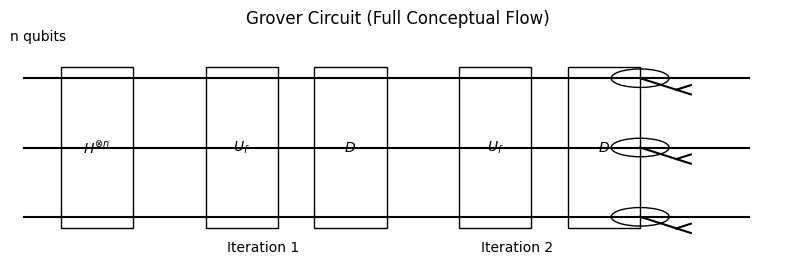

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,3))

# Number of wires (n qubits)
n_wires = 3
y_positions = [0.8 - i*0.3 for i in range(n_wires)]

# Draw horizontal wires
for y in y_positions:
    ax.plot([0, 1], [y, y], 'k')

# Helper to draw rectangular blocks
def draw_block(x, y0, y1, label):
    width = 0.1
    height = y0 - y1
    rect = plt.Rectangle((x, y1), width, height, fill=False, edgecolor='black')
    ax.add_patch(rect)
    ax.text(x + width/2, (y0 + y1)/2, label, ha='center', va='center')

# Initial Hadamards
draw_block(0.05, y_positions[0]+0.05, y_positions[-1]-0.05, r'$H^{\otimes n}$')

# Two Grover iterations (can add more if you want)
x_offset = 0.25
for i in range(2):
    draw_block(x_offset, y_positions[0]+0.05, y_positions[-1]-0.05, r'$U_f$')
    draw_block(x_offset+0.15, y_positions[0]+0.05, y_positions[-1]-0.05, r'$D$')
    ax.text(x_offset+0.08, 0.05, f'Iteration {i+1}', ha='center')
    x_offset += 0.35

# Measurement symbols at the end
meas_x = 0.85
for y in y_positions:
    # Draw measurement "meter"
    circle = plt.Circle((meas_x, y), 0.04, fill=False, edgecolor='black')
    ax.add_patch(circle)
    ax.plot([meas_x, meas_x+0.05], [y, y-0.05], 'k')
    ax.plot([meas_x+0.05, meas_x+0.07], [y-0.05, y-0.03], 'k')
    ax.plot([meas_x+0.05, meas_x+0.07], [y-0.05, y-0.07], 'k')

# Labels
ax.text(-0.02, 0.95, 'n qubits', ha='left', va='bottom')
ax.set_xlim(-0.02, 1.05)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('Grover Circuit (Full Conceptual Flow)')
plt.show()


In [12]:
import math
N, M = 8, 1
theta = math.asin(math.sqrt(M/N))
for k in range(4):
    angle = (2*k+1)*theta
    p = math.sin(angle)**2
    print(f"k={k}, angle_deg={math.degrees(angle):.6f}, "
          f"amp_good={math.sin(angle):.6f}, amp_bad={math.cos(angle):.6f}, "
          f"P_success={p:.6f}")


k=0, angle_deg=20.704811, amp_good=0.353553, amp_bad=0.935414, P_success=0.125000
k=1, angle_deg=62.114433, amp_good=0.883883, amp_bad=0.467707, P_success=0.781250
k=2, angle_deg=103.524055, amp_good=0.972272, amp_bad=-0.233854, P_success=0.945312
k=3, angle_deg=144.933677, amp_good=0.574524, amp_bad=-0.818488, P_success=0.330078


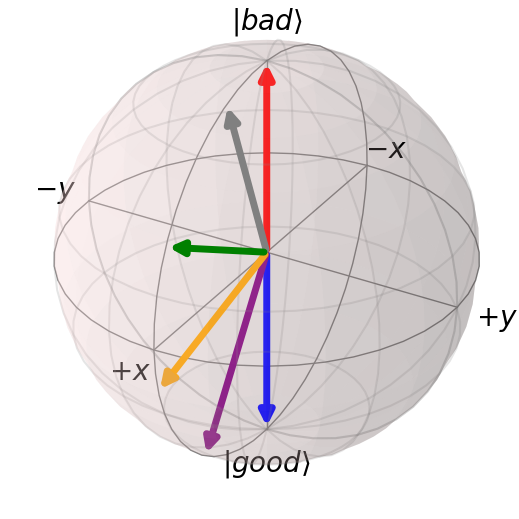

In [30]:
from qiskit.visualization.bloch import Bloch
import numpy as np

# Grover angle (from worked example)
theta = np.deg2rad(20.7048)

# Compute state amplitudes for iterations k=0..3
iterations = [0, 1, 2, 3]
states = []
for k in iterations:
    alpha = np.cos((2*k+1)*theta/2)  # amplitude of |bad>
    beta  = np.sin((2*k+1)*theta/2)  # amplitude of |good>
    states.append([alpha, beta])

# Convert to Bloch sphere vectors
vectors = []
for alpha, beta in states:
    norm = np.sqrt(np.abs(alpha)**2 + np.abs(beta)**2)
    alpha, beta = alpha/norm, beta/norm
    x = 2 * (alpha.conjugate() * beta).real
    y = 2 * (alpha.conjugate() * beta).imag
    z = (np.abs(alpha)**2 - np.abs(beta)**2).real
    vectors.append([x, y, z])

# Initialize Bloch sphere
bloch = Bloch()

# Add reference axis vectors for |bad> (south) and |good> (north)
bloch.add_vectors([0, 0, -1])  # |bad⟩
bloch.add_vectors([0, 0,  1])  # |good⟩

# Add Grover state vectors for iterations k=0..3
for vec in vectors:
    bloch.add_vectors(vec)

# Assign colors: gray=|bad>, blue=|good>, then Grover states
bloch.vector_color = ['blue', 'red', 'gray', 'green', 'orange', 'purple']

# Custom axis labels
bloch.xlabel = ['$+x$', '$-x$']
bloch.ylabel = ['$+y$', '$-y$']
bloch.zlabel = ['$|bad⟩$', '$|good⟩$']

# Show Bloch sphere
bloch.show()



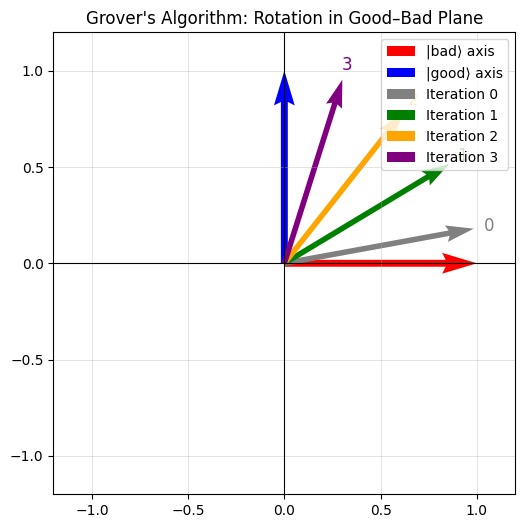

Saved figure: grover_plane.png


In [29]:
import numpy as np
import matplotlib.pyplot as plt

# --- Grover angle from worked example ---
theta = np.deg2rad(20.7048)

# --- State vectors in {|bad>, |good>} plane for k=0..3 ---
iterations = [0, 1, 2, 3]
state_vectors = [
    np.array([np.cos((2*k+1)*theta/2), np.sin((2*k+1)*theta/2)])
    for k in iterations
]

plt.figure(figsize=(6, 6))

# Axes lines
plt.axhline(0, color="black", linewidth=0.8)
plt.axvline(0, color="black", linewidth=0.8)

# --- Reference arrows for |bad> (red) and |good> (blue) ---
plt.quiver(0, 0, 1, 0, angles="xy", scale_units="xy", scale=1,
           color="red", width=0.015, label="|bad⟩ axis")
plt.quiver(0, 0, 0, 1, angles="xy", scale_units="xy", scale=1,
           color="blue", width=0.015, label="|good⟩ axis")

# --- Plot Grover iteration state vectors ---
colors = ["gray", "green", "orange", "purple"]
for k, vec in zip(iterations, state_vectors):
    x, y = vec
    plt.quiver(0, 0, x, y,
               angles="xy", scale_units="xy", scale=1,
               color=colors[k], width=0.012, label=f"Iteration {k}")
    plt.text(x*1.08, y*1.08, f"{k}", fontsize=12,
             color=colors[k], ha="center", va="center")

# Formatting
plt.gca().set_aspect("equal", adjustable="box")
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.title("Grover's Algorithm: Rotation in Good–Bad Plane")
plt.grid(True, linewidth=0.5, alpha=0.5)
plt.legend(loc="upper right")

# Save and/or show
plt.savefig("grover_plane.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved figure: grover_plane.png")



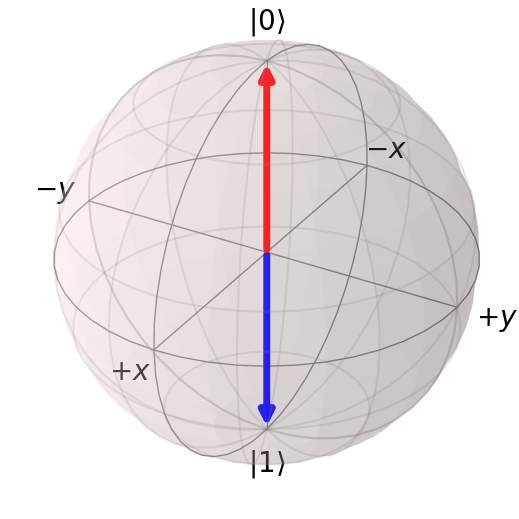

In [ ]:
from qiskit.visualization.bloch import Bloch
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Pauli
import numpy as np

def state_to_bloch(state):
    """Convert a Statevector to a Bloch vector [x, y, z]."""
    rho = DensityMatrix(state)
    x = np.real(np.trace(rho.data @ Pauli("X").to_matrix()))
    y = np.real(np.trace(rho.data @ Pauli("Y").to_matrix()))
    z = np.real(np.trace(rho.data @ Pauli("Z").to_matrix()))
    return [x, y, z]

# Initialize Bloch sphere
bloch = Bloch()

#Input |00>
qc0 = QuantumCircuit(2)
qc0.cx(0)                          # CNOT on |00⟩
state0 = Statevector.from_instruction(qc0)
bloch.add_vectors(state_to_bloch(state0))

#Input |01⟩
qc1 = QuantumCircuit(2)
qc1.x(0)                          # |1⟩
qc1.cx(0)                          # CNOT on |01⟩
state1 = Statevector.from_instruction(qc1)
bloch.add_vectors(state_to_bloch(state1))

#Input |10⟩
qc0 = QuantumCircuit(2)
qc0.cx(0)                          # CNOT on |10⟩
state0 = Statevector.from_instruction(qc0)
bloch.add_vectors(state_to_bloch(state0))

#Input |11⟩
qc1 = QuantumCircuit(2)
qc1.x(0)                          # |1⟩
qc1.cx(0)                          # CNOT on |11⟩
state1 = Statevector.from_instruction(qc1)
bloch.add_vectors(state_to_bloch(state1))

# Assign colors for clarity
bloch.vector_color = ['r', 'b', 'g', 'p']  # red = X|0⟩, blue = X|1⟩

# Custom axis labels
bloch.xlabel = ['$+x$', '$-x$']
bloch.ylabel = ['$+y$', '$-y$']
bloch.zlabel = ['$|0⟩$', '$|1⟩$']

# Show sphere
bloch.show()


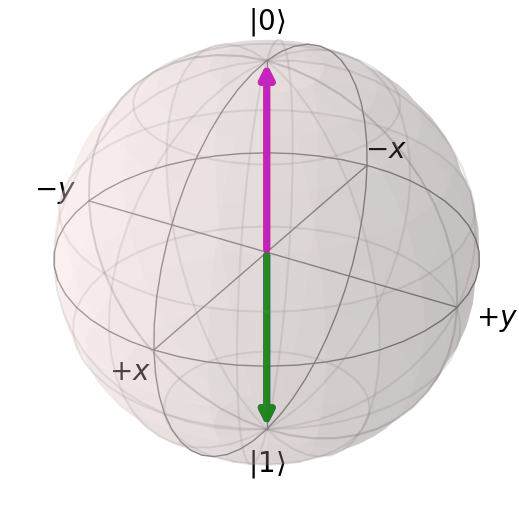

In [66]:
from qiskit.visualization.bloch import Bloch
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Pauli, partial_trace
import numpy as np

def state_to_bloch(state, qubit_index=0):
    """Convert a multi-qubit Statevector to a Bloch vector [x, y, z] for one qubit."""
    rho = DensityMatrix(state)
    # Trace out everything except the qubit we want
    reduced = partial_trace(rho, [i for i in range(rho.num_qubits) if i != qubit_index])
    reduced = DensityMatrix(reduced)
    x = np.real(np.trace(reduced.data @ Pauli("X").to_matrix()))
    y = np.real(np.trace(reduced.data @ Pauli("Y").to_matrix()))
    z = np.real(np.trace(reduced.data @ Pauli("Z").to_matrix()))
    return [x, y, z]

# Initialize Bloch sphere
bloch = Bloch()

# Define input circuits for |00>, |01>, |10>, |11>
inputs = {
    "|00⟩": QuantumCircuit(2),
    "|01⟩": QuantumCircuit(2),
    "|10⟩": QuantumCircuit(2),
    "|11⟩": QuantumCircuit(2)
}

# Prepare the 4 inputs
inputs["|01⟩"].x(1)         # flip target to 1
inputs["|10⟩"].x(0)         # flip control to 1
inputs["|11⟩"].x([0,1])     # flip both

# Apply CNOT and get Bloch vectors (for target qubit index=1)
colors = ['r', 'b', 'g', 'm']
for i, (label, circ) in enumerate(inputs.items()):
    circ.cx(0,1)  # apply CNOT (control=0, target=1)
    state = Statevector.from_instruction(circ)
    bloch.add_vectors(state_to_bloch(state, qubit_index=1))
    
# Assign colors
bloch.vector_color = colors

# Custom axis labels
bloch.xlabel = ['$+x$', '$-x$']
bloch.ylabel = ['$+y$', '$-y$']
bloch.zlabel = ['$|0⟩$', '$|1⟩$']

# Show sphere
bloch.show()


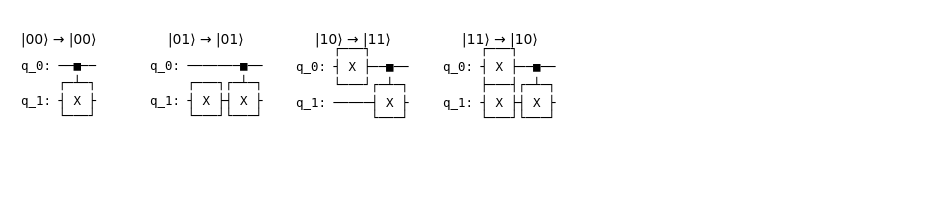

In [44]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

# Build a single CNOT (control=0, target=1)
cnot = QuantumCircuit(2)
cnot.cx(0, 1)

def prep_from_bits(b0, b1):
    qc = QuantumCircuit(2)
    if b0: qc.x(0)
    if b1: qc.x(1)
    return qc

def most_probable_bitstring(sv):
    probs = sv.probabilities_dict()
    out_q1q0 = max(probs, key=probs.get)
    q1, q0 = out_q1q0[0], out_q1q0[1]
    return q0 + q1

inputs = {
    "|00⟩": (0, 0),
    "|01⟩": (0, 1),
    "|10⟩": (1, 0),
    "|11⟩": (1, 1),
}

fig, axes = plt.subplots(1, 4, figsize=(12, 2.4))

for ax, (label, (b0, b1)) in zip(axes, inputs.items()):
    prep = prep_from_bits(b0, b1)
    full = prep.compose(cnot)
    sv = Statevector.from_instruction(full)
    out_bits = most_probable_bitstring(sv)

    # ASCII diagram
    ascii_art = full.draw("text")

    # Label close to diagram
    ax.text(0.1, 0.8, f"{label} → |{out_bits}⟩", fontsize=10,
            ha="center", va="bottom")
    ax.text(0.1, 0.6, ascii_art, fontsize=9, family="monospace",
            ha="center", va="center")

    ax.axis("off")

plt.subplots_adjust(wspace=-0.7, hspace=0.0)
plt.savefig("cnot_all_cases_tight.svg", bbox_inches="tight")
plt.show()


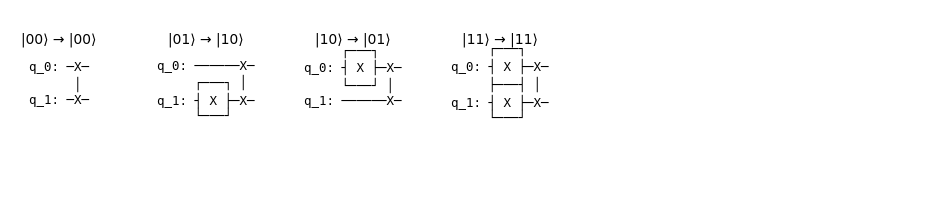

In [45]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

# Build a SWAP gate (swap q0 and q1)
swap = QuantumCircuit(2)
swap.swap(0, 1)

def prep_from_bits(b0, b1):
    qc = QuantumCircuit(2)
    if b0: qc.x(0)
    if b1: qc.x(1)
    return qc

def most_probable_bitstring(sv):
    probs = sv.probabilities_dict()
    out_q1q0 = max(probs, key=probs.get)
    q1, q0 = out_q1q0[0], out_q1q0[1]
    return q0 + q1

inputs = {
    "|00⟩": (0, 0),
    "|01⟩": (0, 1),
    "|10⟩": (1, 0),
    "|11⟩": (1, 1),
}

fig, axes = plt.subplots(1, 4, figsize=(12, 2.4))

for ax, (label, (b0, b1)) in zip(axes, inputs.items()):
    prep = prep_from_bits(b0, b1)
    full = prep.compose(swap)
    sv = Statevector.from_instruction(full)
    out_bits = most_probable_bitstring(sv)

    # ASCII diagram
    ascii_art = full.draw("text")

    # Label close to diagram
    ax.text(0.1, 0.8, f"{label} → |{out_bits}⟩", fontsize=10,
            ha="center", va="bottom")
    ax.text(0.1, 0.6, ascii_art, fontsize=9, family="monospace",
            ha="center", va="center")

    ax.axis("off")

plt.subplots_adjust(wspace=-0.7, hspace=0.0)
plt.savefig("swap_all_cases_tight.svg", bbox_inches="tight")
plt.show()


     ┌───┐┌───┐               
q_0: ┤ H ├┤ T ├──■────────────
     ├───┤└───┘┌─┴─┐┌───┐┌───┐
q_1: ┤ X ├─────┤ X ├┤ H ├┤ T ├
     └───┘     └───┘└───┘└───┘


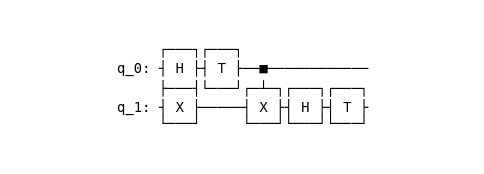

In [47]:
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt

# Build a circuit showing a universal gate set in action
qc = QuantumCircuit(2)

# Apply some 1-qubit gates
qc.h(0)       # Hadamard on qubit 0
qc.t(0)       # T gate on qubit 0
qc.x(1)       # Pauli-X on qubit 1

# Apply a 2-qubit entangling gate
qc.cx(0, 1)   # CNOT between qubit 0 and 1

# Add another layer to show flexibility
qc.h(1)
qc.t(1)

# Draw ASCII version
ascii_art = qc.draw("text")
print(ascii_art)

# Save as SVG using matplotlib text export
plt.figure(figsize=(6, 2))
plt.text(0.5, 0.5, ascii_art, fontsize=10, family="monospace",
         ha="center", va="center")
plt.axis("off")
plt.savefig("universal_gate_circuit.svg", bbox_inches="tight")
plt.show()


     ┌───┐     ┌──────────────┐┌──────────────┐┌─┐   
q_0: ┤ H ├─────┤0             ├┤0             ├┤M├───
     ├───┤     │              ││  circuit-583 │└╥┘┌─┐
q_1: ┤ H ├─────┤1 circuit-580 ├┤1             ├─╫─┤M├
     ├───┤┌───┐│              │└──────────────┘ ║ └╥┘
q_2: ┤ X ├┤ H ├┤2             ├─────────────────╫──╫─
     └───┘└───┘└──────────────┘                 ║  ║ 
c: 2/═══════════════════════════════════════════╩══╩═
                                                0  1 


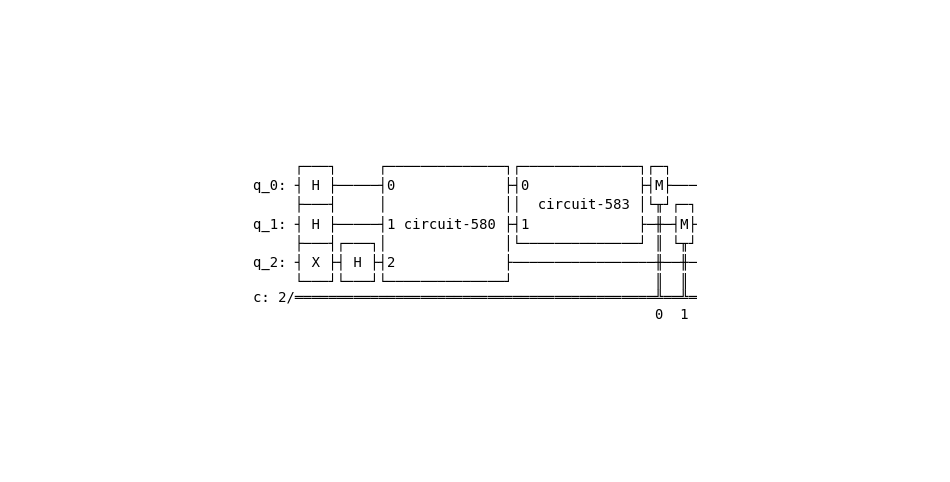

In [54]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import MCXGate
import matplotlib.pyplot as plt

# Oracle function: marks a given bitstring target
def oracle(n, target):
    qc = QuantumCircuit(n+1)  # n data qubits + 1 ancilla
    # Flip qubits where target has "0"
    for i, bit in enumerate(target):
        if bit == "0":
            qc.x(i)
    # Multi-controlled Z (via ancilla trick)
    qc.h(n)  # prepare ancilla
    qc.mcx(list(range(n)), n)  # controlled-X with n controls
    qc.h(n)
    # Undo the flips
    for i, bit in enumerate(target):
        if bit == "0":
            qc.x(i)
    return qc

# Diffusion operator (inversion about the mean)
def diffusion_operator(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.append(MCXGate(n-1), list(range(n)))  # multi-controlled X
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    return qc

# General Grover’s algorithm builder
def grover_circuit(n, target, iterations=1):
    qc = QuantumCircuit(n+1, n)  # n data qubits + 1 ancilla, measure only data
    # Step 1: Initialization
    qc.h(range(n))       # superposition on data qubits
    qc.x(n)              # ancilla into |-⟩
    qc.h(n)

    # Step 2: Grover iterations
    for _ in range(iterations):
        # Oracle
        qc.append(oracle(n, target), range(n+1))
        # Diffusion
        qc.append(diffusion_operator(n), range(n))

    # Step 3: Measurement (only data qubits)
    qc.measure(range(n), range(n))
    return qc

# Example: 2-qubit Grover’s algorithm, target = "11", 1 iteration
qc = grover_circuit(2, "11", iterations=1)

# ASCII diagram
ascii_art = qc.draw("text")
print(ascii_art)

# Save ASCII diagram as SVG
plt.figure(figsize=(12, 6))
plt.text(0.5, 0.5, ascii_art, fontsize=10, family="monospace",
         ha="center", va="center")
plt.axis("off")
plt.savefig("grover_general.svg", bbox_inches="tight")
plt.show()


     ┌───┐┌───┐                    
q_0: ┤ H ├┤ T ├──■────■────────────
     ├───┤└───┘┌─┴─┐  │            
q_1: ┤ X ├─────┤ X ├──■────────────
     └───┘     └───┘┌─┴─┐┌───┐┌───┐
q_2: ───────────────┤ X ├┤ H ├┤ T ├
                    └───┘└───┘└───┘


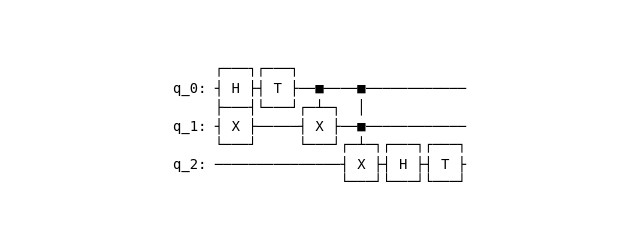

In [48]:
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt

# 3-qubit circuit to include CCNOT (Toffoli)
qc = QuantumCircuit(3)

# Apply single-qubit gates
qc.h(0)       # Hadamard on q0
qc.t(0)       # T gate on q0
qc.x(1)       # Pauli-X on q1

# Add entangling gates
qc.cx(0, 1)   # CNOT between q0 (control) and q1 (target)

# Add a CCNOT (Toffoli) gate
qc.ccx(0, 1, 2)   # q0 & q1 control, q2 target

# Add some more variety
qc.h(2)
qc.t(2)

# ASCII diagram
ascii_art = qc.draw("text")
print(ascii_art)

# Save ASCII diagram as SVG
plt.figure(figsize=(8, 3))
plt.text(0.5, 0.5, ascii_art, fontsize=10, family="monospace",
         ha="center", va="center")
plt.axis("off")
plt.savefig("universal_with_ccnot.svg", bbox_inches="tight")
plt.show()


     ┌───┐        
q_0: ┤ H ├─■──────
     ├───┤ │ ┌───┐
q_1: ┤ X ├─X─┤ T ├
     ├───┤ │ ├───┤
q_2: ┤ T ├─X─┤ H ├
     └───┘   └───┘


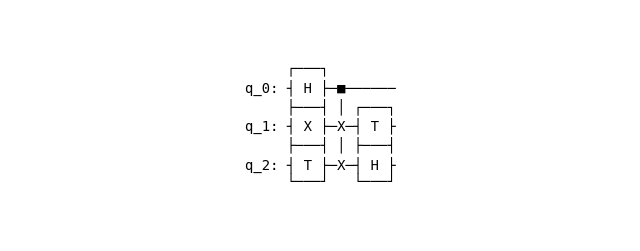

In [49]:
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt

# 3-qubit circuit: Controlled-SWAP (Fredkin gate)
qc = QuantumCircuit(3)

# Add some initial gates (just to show universality in action)
qc.h(0)       # Put control qubit in superposition
qc.x(1)       # Flip qubit 1
qc.t(2)       # T gate on qubit 2

# Controlled-SWAP: control = q0, swap(q1, q2)
qc.cswap(0, 1, 2)

# Add another layer of single-qubit gates
qc.h(2)
qc.t(1)

# ASCII diagram
ascii_art = qc.draw("text")
print(ascii_art)

# Save ASCII diagram as SVG
plt.figure(figsize=(8, 3))
plt.text(0.5, 0.5, ascii_art, fontsize=10, family="monospace",
         ha="center", va="center")
plt.axis("off")
plt.savefig("controlled_swap.svg", bbox_inches="tight")
plt.show()


     ┌───┐               ┌──────────────┐┌─┐   
q_0: ┤ H ├────────────■──┤0             ├┤M├───
     ├───┤            │  │  circuit-594 │└╥┘┌─┐
q_1: ┤ H ├────────────■──┤1             ├─╫─┤M├
     ├───┤┌───┐┌───┐┌─┴─┐└────┬───┬─────┘ ║ └╥┘
q_2: ┤ X ├┤ H ├┤ H ├┤ X ├─────┤ H ├───────╫──╫─
     └───┘└───┘└───┘└───┘     └───┘       ║  ║ 
c: 2/═════════════════════════════════════╩══╩═
                                          0  1 


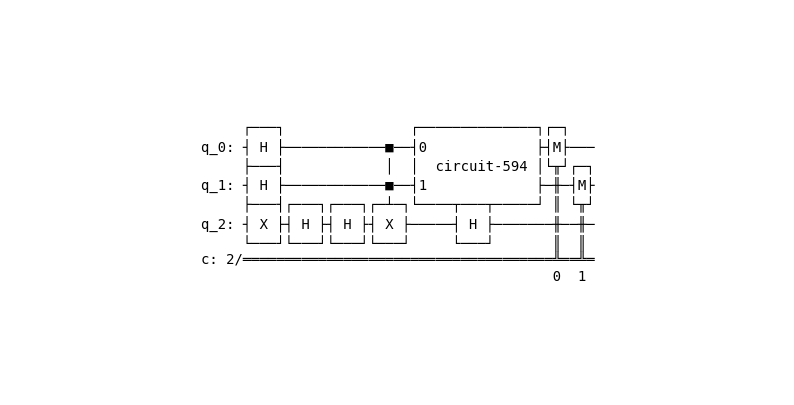

In [56]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import MCXGate
import matplotlib.pyplot as plt

# Function: Grover diffusion operator
def diffusion_operator(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.append(MCXGate(n-1), list(range(n)))  # Multi-controlled X gate
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    return qc

# Main Grover circuit: 2 data qubits + 1 ancilla
qc = QuantumCircuit(3, 2)

# Step 1: Initialization
qc.h([0, 1])     # Put data qubits into superposition
qc.x(2)
qc.h(2)          # Ancilla into |-⟩

# Step 2: Oracle (example: mark |11⟩)
qc.h(2)
qc.ccx(0, 1, 2)  # Controlled-controlled-NOT
qc.h(2)

# Step 3: Diffusion
qc.append(diffusion_operator(2), [0, 1])

# Step 4: Measurement (only data qubits)
qc.measure([0, 1], [0, 1])

# ASCII diagram
ascii_art = qc.draw("text")
print(ascii_art)

# Save ASCII diagram as SVG
plt.figure(figsize=(10, 5))
plt.text(0.5, 0.5, ascii_art, fontsize=10, family="monospace",
         ha="center", va="center")
plt.axis("off")
plt.savefig("grover_algorithm.svg", bbox_inches="tight")
plt.show()


In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import MCXGate

# --- Oracle (high-level gate) ---
def build_oracle(n, target):
    qc = QuantumCircuit(n+1, name=f"Oracle |{target}⟩")
    for i, b in enumerate(target):
        if b == "0":
            qc.x(i)
    qc.h(n)
    qc.append(MCXGate(n), list(range(n)) + [n])
    qc.h(n)
    for i, b in enumerate(target):
        if b == "0":
            qc.x(i)
    return qc.to_gate(label=f"Oracle |{target}⟩")

# --- Diffusion (high-level gate) ---
def build_diffusion(n):
    qc = QuantumCircuit(n, name="Diffusion")
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.append(MCXGate(n-1), list(range(n)))
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    return qc.to_gate(label="Diffusion")

# --- Grover Circuit ---
def grover_circuit(n, target, iterations=1):
    qc = QuantumCircuit(n+1, n)
    qc.h(range(n))
    qc.x(n)
    qc.h(n)

    ORACLE = build_oracle(n, target)
    DIFF   = build_diffusion(n)

    for _ in range(iterations):
        qc.append(ORACLE, range(n+1))
        qc.append(DIFF, range(n))

    qc.measure(range(n), range(n))
    return qc

# Example: 2-qubit Grover searching for |11>
qc = grover_circuit(2, "11", iterations=1)
qc.draw("mpl")   # High-level block diagram


In [57]:
qc = grover_circuit(2, "11", iterations=1)
print(qc.draw("text"))  # ASCII full decomposition
qc.decompose().draw("mpl")  # Full gate-level diagram


     ┌───┐     ┌──────────────┐┌────────────┐┌─┐   
q_0: ┤ H ├─────┤0             ├┤0           ├┤M├───
     ├───┤     │              ││  Diffusion │└╥┘┌─┐
q_1: ┤ H ├─────┤1 Oracle |11⟩ ├┤1           ├─╫─┤M├
     ├───┤┌───┐│              │└────────────┘ ║ └╥┘
q_2: ┤ X ├┤ H ├┤2             ├───────────────╫──╫─
     └───┘└───┘└──────────────┘               ║  ║ 
c: 2/═════════════════════════════════════════╩══╩═
                                              0  1 


MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."